# Confidence Intervals

## Confidence Intervals Using NHANES Data
--- 
#### Confidence Intervals: $Best\ Estimate\ \pm Margin\ of\ Error$
---
##### Formulas:
**Population Proportions**

$\hat{p} \pm z^**\sqrt{\frac{\hat{p}(1-\hat{p})}{n}} $

**Population Mean**

$\bar{x} \pm t^* * (\frac{S}{\sqrt{n}}) $

**Standard Error For Difference of Two Proportions or Means** 

$\sqrt{(SE_{1})^2+(SE_{2})^2}$

---

$\hat{p}$ sample proportion

$\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$ estimated standard error for sample proportion

$z^*$ Z-score

$\bar{x}$ sample mean

$(\frac{S}{\sqrt{n}})$ estimated standard error for the sample mean

$n$ sample size

$t^*$ comes from *t-distribution* table with *n-1* degrees of freedom. This is used when $n < 30$ and the population standard deviation is not known. Otherwise we can use Z-Score

In [1]:
# Initial Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from pathlib import Path
%matplotlib inline
pd.options.display.max_columns=50

In [2]:
df = pd.read_csv(Path('data/nhanes_2015_2016.csv'))
display(df.shape)
df.head()

(5735, 28)

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDMARTL,DMDHHSIZ,WTINT2YR,SDMVPSU,SDMVSTRA,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,1.0,2,134671.37,1,125,4.39,128.0,70.0,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,3.0,1,24328.56,1,125,1.32,146.0,88.0,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,1.0,2,12400.01,1,131,1.51,138.0,46.0,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,6.0,1,102718.00,1,131,5.00,132.0,72.0,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,3.0,5,17627.67,2,126,1.23,100.0,70.0,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [3]:
df.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')

### Question 1
Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [4]:
# check for missing values in our columns of interest
df[['RIAGENDR','RIDAGEYR','DMDMARTL','DMDEDUC2']].isna().sum()

RIAGENDR      0
RIDAGEYR      0
DMDMARTL    261
DMDEDUC2    261
dtype: int64

In [5]:
# drop missing values 
df.dropna(subset=['DMDMARTL','DMDEDUC2'], inplace=True)
df[['RIAGENDR','RIDAGEYR','DMDMARTL','DMDEDUC2']].isna().sum()

RIAGENDR    0
RIDAGEYR    0
DMDMARTL    0
DMDEDUC2    0
dtype: int64

In [6]:
def myfunct(x):
    """ This function will be used to generalize marital status as either married or unmarried """
    if x == 1:
        return 'Married'
    else:
        return 'Not Married'    

In [7]:
# Replace gender code for male and female
df['RIAGENDR'] = df['RIAGENDR'].replace({1:'Male',2:'Female'})

# Replace code for Adults 20+, DMDEDUC2 column
df['DMDEDUC2'] = df['DMDEDUC2'].replace(
    {
        1:'Less than 9th grade',
        2:'9-11th grade',
        3:'Highschool graduate',
        4:'Some college',
        5:'College graduate',
        7:'Refused',
        9:"Don't Know"        
    })

# Classify DMDMARTL column as either married or unmarried.
df['DMDMARTL'] = df['DMDMARTL'].apply(myfunct)

In [8]:
# Restric population sample to women between 35 and 50 years old 
sample_df = df[(df['RIDAGEYR']>=35)&(df['RIDAGEYR']<=50)&(df['RIAGENDR']=='Female')]
print("Shape of Sample Dataframe")
display(sample_df.shape)
print("Unique Values  Count for Education Level")
display(sample_df['DMDEDUC2'].value_counts())
print("Unique Value Count for Marital Status")
display(sample_df['DMDMARTL'].value_counts())
sample_df.sample(5)

Shape of Sample Dataframe


(787, 28)

Unique Values  Count for Education Level


Some college           257
College graduate       234
Highschool graduate    133
Less than 9th grade     83
9-11th grade            80
Name: DMDEDUC2, dtype: int64

Unique Value Count for Marital Status


Married        449
Not Married    338
Name: DMDMARTL, dtype: int64

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDMARTL,DMDHHSIZ,WTINT2YR,SDMVPSU,SDMVSTRA,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
4880,92198,1.0,NaN,2.0,2,Female,47,4,1.0,Some college,Married,5,36302.13,1,129,NaN,130.0,74.0,132.0,76.0,95.3,165.5,34.8,38.0,39.7,44.3,106.0,2.0
3702,90111,1.0,NaN,1.0,2,Female,36,3,1.0,College graduate,Not Married,4,41051.89,1,127,1.72,130.0,88.0,124.0,88.0,53.9,159.7,21.1,NaN,NaN,NaN,NaN,2.0
3011,88907,2.0,1.0,NaN,2,Female,44,1,2.0,Some college,Married,4,26823.52,1,127,1.55,130.0,84.0,126.0,82.0,57.2,160.3,22.3,36.3,35.9,27.0,81.2,2.0
2108,87297,1.0,NaN,1.0,2,Female,46,5,1.0,College graduate,Married,5,25549.80,2,124,4.22,108.0,76.0,100.0,84.0,82.6,163.5,30.9,35.6,36.0,34.5,96.1,2.0
852,85209,1.0,NaN,3.0,2,Female,43,3,1.0,Some college,Not Married,3,93933.12,1,131,2.74,100.0,72.0,102.0,68.0,70.7,166.3,25.6,39.5,37.7,28.2,88.5,1.0


In [9]:
pd.crosstab(sample_df['DMDMARTL'],sample_df['DMDEDUC2'])

DMDEDUC2,9-11th grade,College graduate,Highschool graduate,Less than 9th grade,Some college
DMDMARTL,,,,,
Married,43,162,64,41,139
Not Married,37,72,69,42,118


In [10]:
print('Sample proportion for married females that have finished college\n',pd.crosstab(sample_df['DMDMARTL'],sample_df['DMDEDUC2']).iloc[0,1]/449)

Sample proportion for married females that have finished college
 0.36080178173719374


In [11]:
# lambda function will count the number of college graduates in each group and divides by the size of the population in each group
sample_df = sample_df.groupby('DMDMARTL').agg({'DMDEDUC2': [lambda x: np.mean(x=='College graduate'),np.size]})
sample_df.columns = ['proportion','n']
sample_df

,proportion,n
DMDMARTL,,
Married,0.360802,449
Not Married,0.213018,338


In [12]:
# Calculate 95% confidence interval for married female population
# z-score at 95% = 1.96
p = sample_df.loc['Married','proportion']
n = sample_df.loc['Married','n']

# calculate standard error
se_married = np.sqrt((p*(1-p))/n)

# caluculate confidence interval
lower_bound, upper_bound =  round(p - 1.96 * se_married,4), round(p + 1.96 * se_married,4)

print(f"Standard error for population proportion for married females who have completed college: {round(se_married,4)}")
print(f"Estimated population proportion for married females who have completed college: {round(p,4)}")
print(f"95% confidence interval for married female population: {lower_bound, upper_bound}")
print(f"Range of interval: {round(upper_bound-lower_bound,4)}")
#sm.stats.proportion_confint(162, 449)  

Standard error for population proportion for married females who have completed college: 0.0227
Estimated population proportion for married females who have completed college: 0.3608
95% confidence interval for married female population: (0.3164, 0.4052)
Range of interval: 0.0888


In [13]:
# Calculate 95% confidence interval for unmarried female population
p = sample_df.loc['Not Married','proportion']
n = sample_df.loc['Not Married','n']

# calculate standard error
se_unmarried = np.sqrt((p*(1-p))/n)

# caluculate confidence interval
lower_bound, upper_bound =  round(p - 1.96 * se_unmarried,4), round(p + 1.96 * se_unmarried,4)

print(f"Standard error for population proportion for unmarried females who have completed college: {round(se_unmarried,4)}")
print(f"Estimated population proportion for unmarried females who have completed college: {round(p,4)}")
print(f"95% confidence interval for unmarried female population: {lower_bound, upper_bound}")
print(f"Range of interval: {round(upper_bound-lower_bound,4)}")
#sm.stats.proportion_confint(162, 449)  

Standard error for population proportion for unmarried females who have completed college: 0.0223
Estimated population proportion for unmarried females who have completed college: 0.213
95% confidence interval for unmarried female population: (0.1694, 0.2567)
Range of interval: 0.0873


The confidence interval for the currently married females who have graduated college is wider than the confidence interval for the currently unmarried females who have graduated college. This is because confidence intervals are connected to standard errors. In our parameters of interest, the margin of error for females that are currently married and have completed college is greater than the other group. 

Based on our findings, we are 95% confident that the population proportion for currently married females between the ages of 35 and 50 that have completed college, is estimated to be between (0.3164, 0.4052). 

With a 95% confidence , the population proportion for currently unmarried females between the ages of 35 and 50 that have completed college, is estimated to be between (0.1694, 0.2567).

---
## Question 2
Construct a 95% confidence interval for the proportion of smokers who are female. Construct a 95% confidence interval for the proportion of smokers who are male. Construct a 95% confidence interval for the **difference** between those two gender proportions.

[SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020): smoked at least 100 cigarrates in life, is classified as smoker

In [14]:
# change SMQ020 code into labels
df['SMQ020'] = df['SMQ020'].apply(lambda x: 'Yes' if x==1 else 'No')

# separate data to include gender and smoker classification columns
sample_df = df[['RIAGENDR', 'SMQ020']].dropna()
sample_df.head()

,RIAGENDR,SMQ020
0,Male,Yes
1,Male,Yes
2,Male,Yes
3,Female,No
4,Female,No


In [15]:
# create frequency table for the proportion of smokers in the female and male population
table = pd.crosstab(sample_df['RIAGENDR'],sample_df['SMQ020'])
table

SMQ020,No,Yes
RIAGENDR,,
Female,1953,897
Male,1231,1393


In [16]:
# lambda function will count the number of smokers in each group and divide by each population total
sample_df = sample_df.groupby('RIAGENDR').agg({'SMQ020':[lambda x: np.mean(x=='Yes'),np.size]})
sample_df.columns =['proportion','n']
sample_df

,proportion,n
RIAGENDR,,
Female,0.314737,2850
Male,0.530869,2624


In [17]:
# calculate 95% confidence interval using statsmodels library for female and male smoker populations
fem_lower_bound, fem_upper_bound = sm.stats.proportion_confint(table.loc['Female','Yes'], sample_df.loc['Female','n'])
male_lower_bound, male_upper_bound =  sm.stats.proportion_confint(table.loc['Male','Yes'], sample_df.loc['Male','n'])

# calculate standard error for population proportion standard error
# female population
p = sample_df.loc['Female','proportion']
n = sample_df.loc['Female','n']
se_female = np.sqrt(p*(1-p)/n)

# male  population
p = sample_df.loc['Male','proportion']
n = sample_df.loc['Male','n']
se_male = np.sqrt(p*(1-p)/n)

# calculate confidence interval for the difference in proportion between male and female smokers
# CI = (p1-p2)+-se_diff
# calculate difference standard error for difference of two proportions
se_diff= np.sqrt(se_female**2 + se_male**2)
p_female = sample_df.loc['Female','proportion']
p_male = sample_df.loc['Male','proportion']
lower_bound, upper_bound = (p_female - p_male) - (1.96*se_diff), (p_female - p_male) + (1.96*se_diff)

print(f"Population proportion for female smoker: {p_female:.2%}")
print(f"Population proportion for male smoker: {p_male:.2%}")
print(f"95% Confidence Interval for Female Smoker Population: ({fem_lower_bound:.2%},{fem_upper_bound:.2%})")
print(f"95% Confidence Interval for Male Smoker Population: ({male_lower_bound:.2%},{male_upper_bound:.2%})")
print(f"Difference in population proportions for the two populations: {p_female-p_male:.2%}")
print(f"Confidence interval for difference in population proportion: ({lower_bound:.2%},{upper_bound:.2%})")

Population proportion for female smoker: 31.47%
Population proportion for male smoker: 53.09%
95% Confidence Interval for Female Smoker Population: (29.77%,33.18%)
95% Confidence Interval for Male Smoker Population: (51.18%,55.00%)
Difference in population proportions for the two populations: -21.61%
Confidence interval for difference in population proportion: (-24.17%,-19.05%)


#### Analysis:
The confidence intervals for each population are narrow and they don't overlap. This indicates that there is a difference in population proportion for females and males that smoke. By computing the *difference in population proportions(female_smokers-male_smokers)*, we can see that the smoker population proportion for males is 21.61% higher than females. Furthermore , we are 95% confident that the range of reasonable values for this difference is estimated to be between (-24.17%,-19.05%). This is consistent with the constructed confidence interval for each sample. The estimated rate for males is higher than females at the lower and upper bound. This observation is strongly supported by a negavite range of values for the confidence interval for the difference in populations proportions. 

---
## Question 3
### Age Stratified Confidence Intervals

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean [Body Mass Index](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI) for females and for males within each age band.

$\bar{x} \pm t^* * (\frac{S}{\sqrt{n}}) $

Note:with 95% confidence level and n > 1000, we can use 1.96 for t*

Body Mass Index is given by `BMXBMI` column

In [18]:
# group data by 10 years age band 
df['agegrp'] = pd.cut(df['RIDAGEYR'], pd.interval_range(start=18, end=90, freq=10))
# compute mean, std, size, and standard error of mean(sem) of BMXBMI for each group
sample_df = df.groupby(["agegrp", "RIAGENDR"]).agg({"BMXBMI": [np.mean, np.std, np.size, lambda x: x.sem()]}).unstack()
# set column names
sample_df.columns = sample_df.columns.set_levels(['mean','std','size','sem'], level=1)
sample_df

BMXBMI                                                       \
               mean                  std             size            sem   
RIAGENDR     Female       Male    Female      Male Female Male    Female   
agegrp                                                                     
(18, 28]  28.238776  27.404474  8.180577  6.853188    442  386  0.389551   
(28, 38]  29.943443  29.697180  7.959097  6.726690    494  467  0.360291   
(38, 48]  31.003733  29.514646  8.044642  6.104950    514  398  0.356572   
(48, 58]  30.787361  29.385132  7.647590  6.151534    454  419  0.360111   
(58, 68]  31.054664  29.232462  7.779502  5.959024    466  470  0.362328   
(68, 78]  30.537818  28.720270  6.780588  5.336652    279  307  0.408885   
(78, 88]  27.850000  27.464368  5.483781  4.695650    201  177  0.389715   

                    
                    
RIAGENDR      Male  
agegrp              
(18, 28]  0.351561  
(28, 38]  0.313293  
(38, 48]  0.306785  
(48, 58]  0.301242  
(58, 68]  0.278143  
(68, 78]  0.310187  
(78, 88]  0.355976

In [19]:
# calculate the mean differene between females and males within each band group
sample_df[('BMXBMI', 'mean_diff', '')] = sample_df[('BMXBMI', 'mean', 'Female')] - sample_df[('BMXBMI', 'mean', 'Male')]

# calculate the standard error for differences of mean for each band group
# standard error  of each group is the std
sample_df[('BMXBMI', 'sem_diff', '')] = np.sqrt(sample_df[('BMXBMI', 'sem', 'Female')]**2 + sample_df[('BMXBMI', 'sem', 'Male')]**2)

# calculate 95% confidence interval(large samples: t* = 1.96)
sample_df[('BMXBMI','ci_lower_bound','')] = sample_df[('BMXBMI','mean_diff','')] - 1.96 * sample_df[('BMXBMI','sem_diff','')]
sample_df[('BMXBMI','ci_upper_bound','')] = sample_df[('BMXBMI','mean_diff','')] + 1.96 * sample_df[('BMXBMI','sem_diff','')]
sample_df


BMXBMI                                                       \
               mean                  std             size            sem   
RIAGENDR     Female       Male    Female      Male Female Male    Female   
agegrp                                                                     
(18, 28]  28.238776  27.404474  8.180577  6.853188    442  386  0.389551   
(28, 38]  29.943443  29.697180  7.959097  6.726690    494  467  0.360291   
(38, 48]  31.003733  29.514646  8.044642  6.104950    514  398  0.356572   
(48, 58]  30.787361  29.385132  7.647590  6.151534    454  419  0.360111   
(58, 68]  31.054664  29.232462  7.779502  5.959024    466  470  0.362328   
(68, 78]  30.537818  28.720270  6.780588  5.336652    279  307  0.408885   
(78, 88]  27.850000  27.464368  5.483781  4.695650    201  177  0.389715   

                                                                      
                   mean_diff  sem_diff ci_lower_bound ci_upper_bound  
RIAGENDR      Male                                                    
agegrp                                                                
(18, 28]  0.351561  0.834302  0.524734      -0.194176       1.862780  
(28, 38]  0.313293  0.246263  0.477454      -0.689548       1.182073  
(38, 48]  0.306785  1.489086  0.470384       0.567134       2.411039  
(48, 58]  0.301242  1.402230  0.469496       0.482017       2.322442  
(58, 68]  0.278143  1.822202  0.456777       0.926919       2.717484  
(68, 78]  0.310187  1.817548  0.513228       0.811622       2.823474  
(78, 88]  0.355976  0.385632  0.527823      -0.648901       1.420165

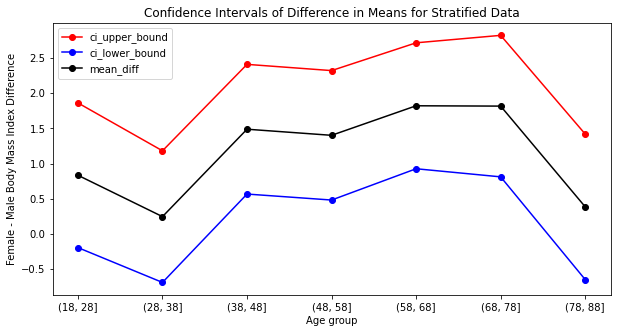

In [20]:
# create list of index from dataframe index values(easier to plot when dealing multi level index) 
x_tickers = [str(x) for x in sample_df.index.values]
# plot data
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_tickers,sample_df[('BMXBMI','ci_upper_bound','')], color='red', label='ci_upper_bound',marker='o')
ax.plot(x_tickers,sample_df[('BMXBMI','ci_lower_bound','')], color='blue', label='ci_lower_bound',marker='o')
ax.plot(x_tickers,sample_df[('BMXBMI','mean_diff','')],color='black', label='mean_diff',marker='o')
ax.legend()
plt.ylabel('Female - Male Body Mass Index Difference')
plt.xlabel('Age group')
plt.title('Confidence Intervals of Difference in Means for Stratified Data')
plt.show(fig)

In [21]:
# summary statistics
sample_df.describe()

BMXBMI                                                         \
               mean                  std                  size               
RIAGENDR     Female       Male    Female      Male      Female        Male   
count      7.000000   7.000000  7.000000  7.000000    7.000000    7.000000   
mean      29.916542  28.774076  7.410825  5.975384  407.142857  374.857143   
std        1.335904   0.964202  0.965878  0.755952  118.850647  103.201144   
min       27.850000  27.404474  5.483781  4.695650  201.000000  177.000000   
25%       29.091109  28.092319  7.214089  5.647838  360.500000  346.500000   
50%       30.537818  29.232462  7.779502  6.104950  454.000000  398.000000   
75%       30.895547  29.449889  8.001870  6.439112  480.000000  443.000000   
max       31.054664  29.697180  8.180577  6.853188  514.000000  470.000000   

                                                                                
               sem           mean_diff  sem_diff ci_lower_bound ci_upper_bound  
RIAGENDR    Female      Male                                                    
count     7.000000  7.000000  7.000000  7.000000       7.000000       7.000000  
mean      0.375351  0.316741  1.142466  0.491414       0.179295       2.105637  
std       0.020469  0.027796  0.655279  0.029521       0.680823       0.634001  
min       0.356572  0.278143  0.246263  0.456777      -0.689548       1.182073  
25%       0.360201  0.304014  0.609967  0.469940      -0.421539       1.641473  
50%       0.362328  0.310187  1.402230  0.477454       0.482017       2.322442  
75%       0.389633  0.332427  1.653317  0.518981       0.689378       2.564262  
max       0.408885  0.355976  1.822202  0.527823       0.926919       2.823474

#### Analysis
The overall average difference in body mass index betwen females and males is 1.142, which indicates that the female population is more likely to be overweight. The graph shows that difference in means is the lowest for people in their 20s, and is the highest for people betwen the ages of 50 and 70. We can can also see that the average standard deviation for females and males is 7.411 and 5.975 respectively. This indicates that body mass index within each population varies at a higher rate than the difference between female and male. 
